In [ ]:
!pip install tensorflow pillow matplotlib pandas


In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.applications.efficientnet import preprocess_input
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Build model architecture
base_model = EfficientNetB0(weights="imagenet", include_top=False, input_shape=(224,224,3))
x = base_model.output
x = GlobalAveragePooling2D()(x)
outputs = Dense(11, activation="softmax")(x)  # 11 classes
model = Model(inputs=base_model.input, outputs=outputs)

print("Model architecture created.")

# Uncomment and provide path to your fine-tuned weights if available
# model.load_weights("path_to_finetuned_weights.h5")
# print("Fine-tuned weights loaded.")


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Model architecture created.


In [ ]:
PLANT_DISEASE_CLASSES = [
    "Apple Scab", "Apple Black Rot", "Apple Cedar Apple Rust",
    "Tomato Early Blight", "Tomato Late Blight", "Tomato Leaf Mold",
    "Potato Early Blight", "Potato Late Blight",
    "Grape Black Rot", "Grape Esca (Black Measles)",
    "Healthy"
]


In [ ]:
def preprocess_image(image_path):
    img = Image.open(image_path).convert('RGB').resize((224,224))
    img_array = np.array(img)
    img_array = preprocess_input(img_array)
    img_array = np.expand_dims(img_array, axis=0)
    return img_array


In [ ]:
def predict_disease(image_path):
    img_array = preprocess_image(image_path)
    preds = model.predict(img_array)
    top_idx = np.argmax(preds)
    pred_class = PLANT_DISEASE_CLASSES[top_idx]
    confidence = preds[0][top_idx]
    return pred_class, confidence


In [ ]:
def parse_species_disease(pred_class):
    if pred_class == "Healthy":
        return "Healthy", "Healthy"
    parts = pred_class.split(' ', 1)
    if len(parts) == 2:
        species, disease = parts
    else:
        species, disease = pred_class, "Unknown"
    return species, disease


In [ ]:
spread_time_map = {
    ("Apple", "Scab"): {"hours_per_acre": 36, "days_per_acre": 1.5},
    ("Apple", "Black Rot"): {"hours_per_acre": 48, "days_per_acre": 2},
    ("Apple", "Cedar Apple Rust"): {"hours_per_acre": 72, "days_per_acre": 3},
    ("Tomato", "Early Blight"): {"hours_per_acre": 48, "days_per_acre": 2},
    ("Tomato", "Late Blight"): {"hours_per_acre": 24, "days_per_acre": 1},
    ("Tomato", "Leaf Mold"): {"hours_per_acre": 60, "days_per_acre": 2.5},
    ("Potato", "Early Blight"): {"hours_per_acre": 36, "days_per_acre": 1.5},
    ("Potato", "Late Blight"): {"hours_per_acre": 18, "days_per_acre": 0.75},
    ("Grape", "Black Rot"): {"hours_per_acre": 36, "days_per_acre": 1.5},
    ("Grape", "Esca (Black Measles)"): {"hours_per_acre": 72, "days_per_acre": 3},
    ("Healthy", "Healthy"): {"hours_per_acre": 0, "days_per_acre": 0},
}

def estimate_spread_time(species, disease):
    return spread_time_map.get((species, disease), {"hours_per_acre": None, "days_per_acre": None})


In [ ]:
def plot_spread_time(species, disease, spread):
    if spread["hours_per_acre"] is None:
        print(f"No spread data found for {species} - {disease}")
        return
    plt.bar(["Hours/Acre", "Days/Acre"], [spread["hours_per_acre"], spread["days_per_acre"]], color=['orange', 'green'])
    plt.title(f"Disease Spread Time\n{species} | {disease}")
    plt.ylabel("Time")
    plt.show()


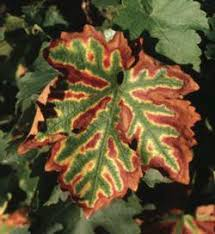

In [ ]:
from IPython.display import display
image_path = "/content/karthiktest.jpg"
img = Image.open(image_path)
display(img)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
Predicted: Potato Early Blight with confidence 17.80%
Species detected: Potato, Disease detected: Early Blight
Estimated spread time: 36 hours/acre, 1.5 days/acre


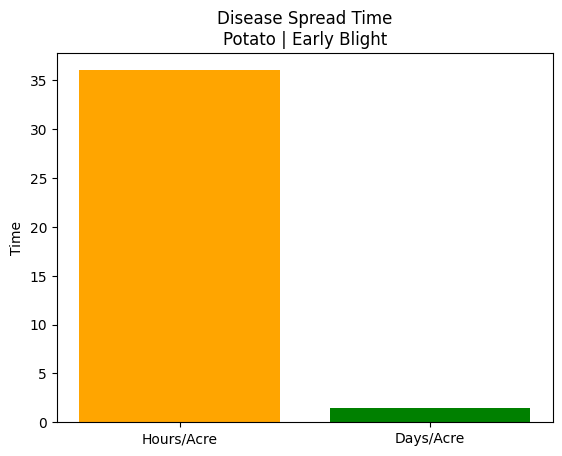

In [ ]:


pred_class, confidence = predict_disease(image_path)
print(f"Predicted: {pred_class} with confidence {confidence*100:.2f}%")

species, disease = parse_species_disease(pred_class)
print(f"Species detected: {species}, Disease detected: {disease}")

spread = estimate_spread_time(species, disease)

if spread["hours_per_acre"] is None:
    print("Spread time data not available for this disease.")
else:
    print(f"Estimated spread time: {spread['hours_per_acre']} hours/acre, {spread['days_per_acre']} days/acre")
    plot_spread_time(species, disease, spread)
